<a href="https://colab.research.google.com/github/densmyslov/bq-hackathon/blob/main/notebooks/1_invoice_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import re
import pandas as pd
import requests
from io import BytesIO
from google.cloud import storage
import requests
import pytz
from datetime import datetime
import json
from typing import Dict, List, Any, Tuple, Optional
from collections import defaultdict
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import storage
gcs_client = storage.Client()

from google.cloud import bigquery
bq_client = bigquery.Client(project='data-science-455302')

In [3]:
bucket_name = BUCKET_NAME = 'trump-political-ads-sample'

# Functions

In [4]:
def show_image_page(bucket_name, blob_path):
  if blob_path.startswith('gs'):
    blob_path = '/'.join(blob_path.split('/')[3:])

  bucket = gcs_client.bucket(bucket_name)
  blob   = bucket.blob(blob_path)

  buf = BytesIO()
  blob.download_to_file(buf)
  buf.seek(0)
  return Image.open(buf)

def show_images(bucket_name, samples, n_cols = 4):
  # Setup grid
  n = len(samples)

  n_rows = (n + n_cols - 1) // n_cols  # ceiling division
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
  axes = axes.flatten()

  for i, (idx, row) in enumerate(samples.iterrows()):
      title = row['file_name']
      image_key = row['image_key']
      bucket_name = image_key.split('/')[2]
      blob_path = '/'.join(image_key.split('/')[3:])

      image = show_image_page(bucket_name, blob_path)

      axes[i].imshow(image)
      axes[i].set_title(title[:50], fontsize=8)  # shorten long titles
      axes[i].axis("off")

  # Hide unused axes
  for j in range(i+1, len(axes)):
      axes[j].axis("off")

  plt.tight_layout()
  plt.show()

def process_result(df):

  raw = df.iloc[0]["json_result"]

  # Strip markdown fences like ```json ... ```
  clean = re.sub(r"^```(?:json)?\s*|\s*```$", "", raw.strip(), flags=re.DOTALL)

  try:
      return json.loads(clean)

  except Exception as e:
      print("❌ JSON parse error:", e)
      print("Raw output:", raw[:500])

# Load table

In [5]:
PROJECT_ID = "data-science-455302"  # your GCP project
REGION = "us-central1"              # region of your connection / dataset
DATASET_ID = "trump_campaign_us_central1"         # dataset to store the remote model
MODEL_NAME = "mistral_medium"       # name for the remote model
SOURCE_TABLE = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FILES"
CONNECTION_RESOURCE = "24627479292.us-central1.576f28e4-61cc-464a-b136-da8b005649c8"

In [6]:
table = bq_client.get_table(SOURCE_TABLE)

## show document example

let's look at the first page of a random document from the table:

gs://trump-political-ads-sample/FCC/docs/56ec94bb-523a-0d22-8d83-49ebe7d3baca/INVOICE Donald J. Trump for President WRAZ EST 11817 100124-100724 359071-1/page_1.png


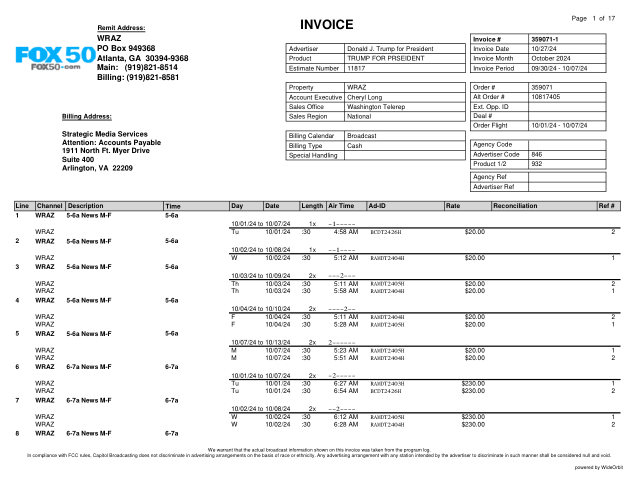

In [99]:

query = f"""
SELECT image_key
FROM `{SOURCE_TABLE}`
WHERE image_key IS NOT NULL
ORDER BY RAND()
LIMIT 1
"""

df = bq_client.query(query).to_dataframe()
image_uri = df['image_key'].tolist()[0]
print(image_uri)
image = show_image_page(bucket_name, image_uri)
image

## document label heuristics

this particular dataset contains a hint in the file names: almost all invoice have either 'inv' or 'invoice' (in varioue cases);  

to save code lines, we are going to shift the whole table into memory and count the number of titles that contain said hint in the file_name:

In [12]:
df = bq_client.query(
    f"""SELECT * FROM `{SOURCE_TABLE}`"""
).to_dataframe()
df.shape

(298, 8)

In [13]:
df.query("file_name.str.contains('INV|Invoice', case=False, regex=True, na=False)").shape

(62, 8)

* we got 62 as the approximate number of invoices in the table consisting of 298 rows with documents.

* we will use this number to estimate the accuracy of  classification

# Invoice classification

## Step 1. Invoice classification: AI.GENERATE_BOOL

* we will be using [AI.GENERATE_BOOL](https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-ai-generate-bool) function

In [7]:
model_endpoint = 'gemini-2.5-pro'

### One-row smoke test

#### Smoke Test – Single Image Classification

This query tests the AI.GENERATE_BOOL function on one sample document image to confirm that the model and connection are working before scaling to the full dataset.

In [ ]:
sql = f"""
WITH src AS (
  SELECT
    image_key,
    REPLACE(
      REPLACE(image_key,
              'gs://trump-political-ads-sample/',
              'https://storage.googleapis.com/trump-political-ads-sample/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE REGEXP_CONTAINS(image_key, r'(?i)\\.png$')  -- case-insensitive .png
  LIMIT 1
)
SELECT
  image_key,
  r.result        AS is_invoice,
  r.status        AS status,
  r.full_response AS full_response
FROM src,
UNNEST([AI.GENERATE_BOOL(
  ('Is this an invoice? Answer strictly True or False.', url),
  connection_id => '{CONNECTION_RESOURCE}',
  endpoint      => '{model_endpoint}'
)]) AS r
"""

df = bq_client.query(sql).to_dataframe()



In [ ]:
df

,image_key,is_invoice,status,full_response
0,gs://trump-political-ads-sample/FCC/docs/02d41...,True,,"{""candidates"":[{""avg_logprobs"":-10.26692047119..."


let's check the image of the first page of the document we classified:

gs://trump-political-ads-sample/FCC/docs/f1f14619-318d-5849-fc15-e68b60b637e6/6209799 - Donald J Trump for President -R/page_1.png
trump-political-ads-sample FCC/docs/a9c19b66-e16c-d69c-ff31-ba02260d5480/95272 Donald J Trump for President 2024 Order R4/page_1.png


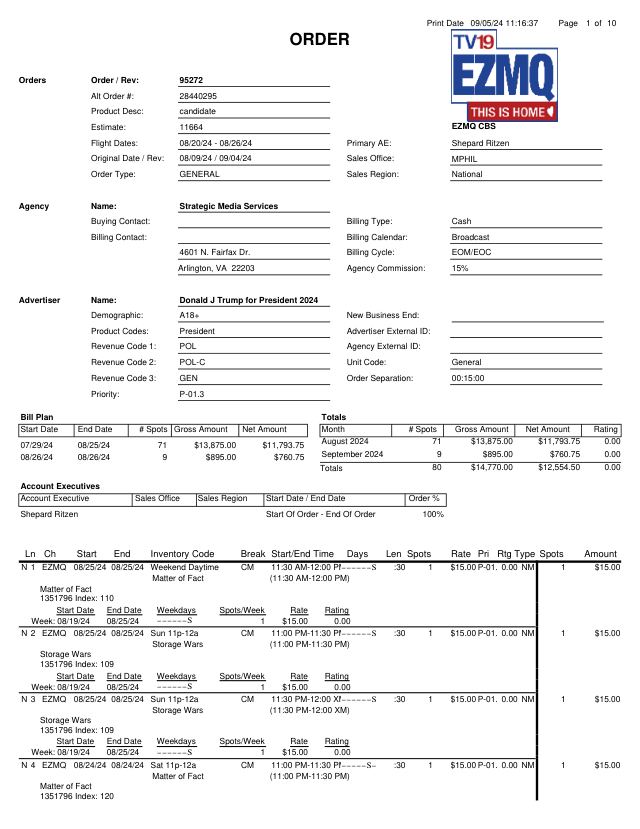

In [ ]:
page_image_key = df['image_key'].tolist()[0]
print(page_image_key)

bucket_name = page_image_key.split('/')[2]
blob_path   = '/'.join(page_image.split('/')[3:])
print(bucket_name, blob_path)
image = show_image_page(bucket_name, blob_path)
image

the model misclassified the document as "invoice", even though the document is an "order".

let's make another classification request suing the same model and method, but this time we will use pdf versin of the document

In [ ]:
resp = df['full_response'].tolist()[0]
resp = json.loads(resp)
resp

{'candidates': [{'avg_logprobs': -18.09344482421875,
   'content': {'parts': [{'text': '{"answer": true}'}], 'role': 'model'},
   'finish_reason': 'STOP',
   'score': -90.46722412109375}],
 'create_time': '2025-09-20T04:52:45.099198Z',
 'model_version': 'gemini-2.5-pro',
 'response_id': 'HTPOaP6GBvKEsbQPxqfV6Ao',
 'usage_metadata': {'billable_prompt_usage': {'text_count': 220},
  'candidates_token_count': 5,
  'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 5}],
  'prompt_token_count': 111,
  'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 111}],
  'thoughts_token_count': 661,
  'total_token_count': 777,
  'traffic_type': 'ON_DEMAND'}}

#### Smoke Test – Single PDF Classification
Here we classify the same document, but using its PDF instead of an image, to compare accuracy between formats.

In [ ]:
pdf_key = image_key.replace('page_1.png','doc.pdf')
print(pdf_key)

sql = f"""
WITH src AS (
  SELECT
    pdf_key,
    REPLACE(
      REPLACE(pdf_key,
              'gs://trump-political-ads-sample/',
              'https://storage.googleapis.com/trump-political-ads-sample/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE REGEXP_CONTAINS(pdf_key, r'(?i)\\.pdf$')  -- case-insensitive .pdf
  QUALIFY ROW_NUMBER() OVER (ORDER BY pdf_key) = 1 -- deterministic single sample
)
SELECT
  pdf_key,
  r.result        AS is_invoice,
  r.status        AS status,
  r.full_response AS full_response
FROM src,
UNNEST([AI.GENERATE_BOOL(
  ('Is this an invoice? Answer strictly True or False.', url),
  connection_id => '{CONNECTION_RESOURCE}',
  endpoint      => '{model_endpoint}'
)]) AS r
"""
df = bq_client.query(sql).to_dataframe()


gs://trump-political-ads-sample/FCC/docs/02d41cf6-ef29-bb8a-4133-aabf796f6d24/DONALD J TRUMP PRESIDENT 2024 WWJ INVOICE 190045389/doc.pdf


In [ ]:
df

,pdf_key,is_invoice,status,full_response
0,gs://trump-political-ads-sample/FCC/docs/02d41...,False,,"{""candidates"":[{""avg_logprobs"":-6.426045989990..."


This time, using the pdf file of the document, the model correctly classified our document as not an invoice ("is_invoice" == False)

In [ ]:
resp = df['full_response'].tolist()[0]
resp = json.loads(resp)
resp

{'candidates': [{'avg_logprobs': -20.644807434082033,
   'content': {'parts': [{'text': '{"answer": true}'}], 'role': 'model'},
   'finish_reason': 'STOP',
   'score': -103.22403717041016}],
 'create_time': '2025-09-20T05:08:31.887065Z',
 'model_version': 'gemini-2.5-pro',
 'response_id': 'zzbOaJmSNqnuhMIPgYu_sAY',
 'usage_metadata': {'billable_prompt_usage': {'text_count': 227},
  'candidates_token_count': 5,
  'candidates_tokens_details': [{'modality': 'TEXT', 'token_count': 5}],
  'prompt_token_count': 113,
  'prompt_tokens_details': [{'modality': 'TEXT', 'token_count': 113}],
  'thoughts_token_count': 609,
  'total_token_count': 727,
  'traffic_type': 'ON_DEMAND'}}

our "smoke test" request showed:
* we should make requests using both image and pdf files, and compare reaults after that;  

* quite a reasonable the token usage

### all rows classification using AI.BOOL function

#### Classify All First-Page Images
This query runs invoice classification on all first-page images in the dataset. Using images greatly reduces token cost compared to PDFs, while still providing a good first-pass classification.

* in the notebook 0 we extarcted images of the first pages of the document files, stored them in a bucket and put links to those images into the column image_key of the BQ table.

* we will use those first-page images to classify the whole documents - we are going to save a lot of input tokens while not compromizing much on the accuracy, since it's usually easy to understand if a document is an invoice by looking at its very first page

In [55]:

DEST_TABLE   = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_IMAGE_FLAGS"


sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    image_key,
    -- Convert to public HTTPS and URL-encode spaces
    REPLACE(
      REPLACE(image_key, 'gs://', 'https://storage.googleapis.com/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE image_key IS NOT NULL
    AND REGEXP_CONTAINS(LOWER(image_key), r'\\.(png|jpg|jpeg)$')
)
SELECT
  image_key,
  AI.GENERATE_BOOL(
    ('Is this image an invoice? Answer strictly True or False.', url),
    connection_id => '{CONNECTION_RESOURCE}',
    endpoint      => '{model_endpoint}'
  ).result AS is_invoice
FROM src
"""
bq_client.query(sql).result()
print("✅ Created:", DEST_TABLE)


✅ Created: data-science-455302.trump_campaign_us_central1.TRUMP_IMAGE_FLAGS


let's check results:

In [56]:
# --- 2) Sanity check
df = bq_client.query(f"""
SELECT
  COUNT(*) AS total,
  COUNTIF(is_invoice IS TRUE)  AS n_true,
  COUNTIF(is_invoice IS FALSE) AS n_false,
  COUNTIF(is_invoice IS NULL)  AS n_null
FROM `{DEST_TABLE}`
""").to_dataframe()
df

,total,n_true,n_false,n_null
0,298,209,89,0


* 209 documents were classified as invoices by using the pdf files

* this result contains a lot of false positives, since we expect smth like 62 true positives (see document `label heuristics` above)

##### Backfill is_invoice_img Column
The results from the image-based classification table are merged back into the source table so that each record now carries its invoice flag (is_invoice_img).$

In [59]:
# 1) Add the target column if it doesn't exist
bq_client.query(f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS is_invoice_img BOOL
""").result()

# 2) Merge flags from the right-hand table
bq_client.query(f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` R
ON T.image_key = R.image_key
WHEN MATCHED THEN
  UPDATE SET T.is_invoice_img = R.is_invoice
""").result()

print("✅ Backfilled is_invoice_img into:", SOURCE_TABLE)



✅ Backfilled is_invoice_img into: data-science-455302.trump_campaign_us_central1.TRUMP_PDF_FILES


#### Classify All PDF Files
Here we repeat the classification using the entire PDF files. This provides a more complete context for the model, at the expense of higher token usage.

* we stored entire pdf files of the dataset in bucket and put links to thesse files in the column `pdf_key` of the table.

* we will do a second classification run by using pdf files for the document classification purpose

In [ ]:
DEST_TABLE   = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_PDF_FLAGS"

sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    pdf_key,
    -- Convert gs://... -> https://storage.googleapis.com/... and URL-encode spaces
    REPLACE(
      REPLACE(pdf_key, 'gs://', 'https://storage.googleapis.com/'),
      ' ', '%20'
    ) AS url
  FROM `{SOURCE_TABLE}`
  WHERE pdf_key IS NOT NULL
    AND REGEXP_CONTAINS(pdf_key, r'(?i)\\.pdf$')  -- case-insensitive .pdf
)
SELECT
  pdf_key,
  AI.GENERATE_BOOL(
    ('Is this document an invoice? Answer strictly True or False.', url),
    connection_id => '{CONNECTION_RESOURCE}',
    endpoint      => '{model_endpoint}'
  ).result AS is_invoice
FROM src
"""
bq_client.query(sql).result()
print("✅ Created:", DEST_TABLE)


✅ Created: data-science-455302.trump_campaign_us_central1.TRUMP_PDF_FLAGS


In [ ]:
# --- 2) Sanity check
df = bq_client.query(f"""
SELECT
  COUNT(*) AS total,
  COUNTIF(is_invoice IS TRUE)  AS n_true,
  COUNTIF(is_invoice IS FALSE) AS n_false,
  COUNTIF(is_invoice IS NULL)  AS n_null
FROM `{DEST_TABLE}`
""").to_dataframe()
df

,total,n_true,n_false,n_null
0,298,184,114,0


* 184 documents were classified as invoices by using the pdf files

* this result contains a lot of false positives, since we expect smth like 62 true positives (see document `label heuristics` above)

##### Backfill is_invoice_pdf Column
The PDF-based classification results are merged into the source table under the is_invoice_pdf column, enabling side-by-side comparison with image-based results.

In [ ]:
# 1) Add the target column if it doesn't exist
bq_client.query(f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS is_invoice_pdf BOOL
""").result()

# 2) Merge flags from the PDF classification table into the source
#    Assumes DEST_TABLE has columns: pdf_key, is_invoice
bq_client.query(f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` R
ON T.pdf_key = R.pdf_key
WHEN MATCHED THEN
  UPDATE SET T.is_invoice_pdf = R.is_invoice
""").result()

print("✅ Backfilled is_invoice_pdf into:", SOURCE_TABLE)


✅ Backfilled is_invoice_pdf into: data-science-455302.trump_campaign_us_central1.TRUMP_PDF_FILES


#### Analyze Overlap Between Image and PDF Results
This query compares records classified as invoices by both methods, helping us evaluate agreement and identify false positives or negatives.

let's compare results of the 2 approaches to the document classification task:
* using first page image
* usuing the entire pdf file

out sample bq table is small, let's extract it to in-memory df for easier manipulations

In [64]:
sql = f"SELECT * FROM `{SOURCE_TABLE}`"
df = bq_client.query(sql).to_dataframe()
df.shape

(298, 6)

how many documents were classified with both methods as True ?

In [66]:
df.query("is_invoice_img==True & is_invoice_pdf==True").shape

/tmp/ipython-input-1345697075.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df.query("is_invoice_img==True & is_invoice_pdf==True").shape


(146, 6)

146 documents were classified both by using the first page image and the entire pdf file as invoices

let's inspect a sample of the df

In [67]:
df.query("is_invoice_img==True & is_invoice_pdf==True").sample(15)

/tmp/ipython-input-555607220.py:1: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df.query("is_invoice_img==True & is_invoice_pdf==True").sample(15)


,pdf_key,file_id,file_name,image_key,is_invoice_pdf,is_invoice_img
283,gs://trump-political-ads-sample/FCC/docs/eee3b...,eee3b61c-833a-bd50-25e2-797314912984,97164-1 Donald J Trump for President 2024 In...,gs://trump-political-ads-sample/FCC/docs/eee3b...,True,True
213,gs://trump-political-ads-sample/FCC/docs/03ff5...,03ff5d45-db4b-fe2c-81c2-dfcd58b125bf,Donald J Trump for President Order 207179,gs://trump-political-ads-sample/FCC/docs/03ff5...,True,True
162,gs://trump-political-ads-sample/FCC/docs/b4fae...,b4fae8e3-a4db-229d-1aa5-52f3f92d2e03,282157-Donald J. Trump for President Inc.-WFPA...,gs://trump-political-ads-sample/FCC/docs/b4fae...,True,True
218,gs://trump-political-ads-sample/FCC/docs/e8cc0...,e8cc0e58-6620-395f-e351-a5ae290eefc8,DONALD TRUMP FOR PRES- 4583782 - NAB,gs://trump-political-ads-sample/FCC/docs/e8cc0...,True,True
269,gs://trump-political-ads-sample/FCC/docs/85a02...,85a023b1-0052-1ceb-c3c8-c4eb30930119,DONALD J TRUMP PRESIDENT 2024 WUPA INVOICE 330...,gs://trump-political-ads-sample/FCC/docs/85a02...,True,True
260,gs://trump-political-ads-sample/FCC/docs/44686...,44686740-5ce8-79de-72ad-3215ca69a0a1,PL24090336,gs://trump-political-ads-sample/FCC/docs/44686...,True,True
198,gs://trump-political-ads-sample/FCC/docs/9d24a...,9d24a9a2-2cb9-e0eb-1c01-aaabfa1e47e5,4110343-1,gs://trump-political-ads-sample/FCC/docs/9d24a...,True,True
259,gs://trump-political-ads-sample/FCC/docs/d39d6...,d39d6f19-fa80-4ebf-12f2-b3d936c616e5,DONALD J TRUMP ORDER 3673559 EST 11806,gs://trump-political-ads-sample/FCC/docs/d39d6...,True,True
275,gs://trump-political-ads-sample/FCC/docs/57036...,570362d8-58e2-25a5-5444-8b96ccf2bef8,DJT 11761 1495960 REV--1,gs://trump-political-ads-sample/FCC/docs/57036...,True,True
156,gs://trump-political-ads-sample/FCC/docs/2517a...,2517aa6d-4e9c-0df5-9e0b-9b46f28949c5,Donald Trump est 11647,gs://trump-political-ads-sample/FCC/docs/2517a...,True,True


* usually Invoices in the political ads campaign contains a hint in the file name indicating that the file is invoice, e.g., "Invoice", "INV", etc.  

* but in the table above there are files with names that do not contain such hints.

* Let's check the images of the first pages of a few of such files.

In [15]:
not_inv_in_title_df = df.query("is_invoice_img == True & is_invoice_pdf == True", engine="python") \
  .loc[lambda x: ~x.file_name.str.contains("INV|Invoice", case=False,
                                           regex=True,
                                           na=False)]

not_inv_in_title_df.shape

(85, 8)

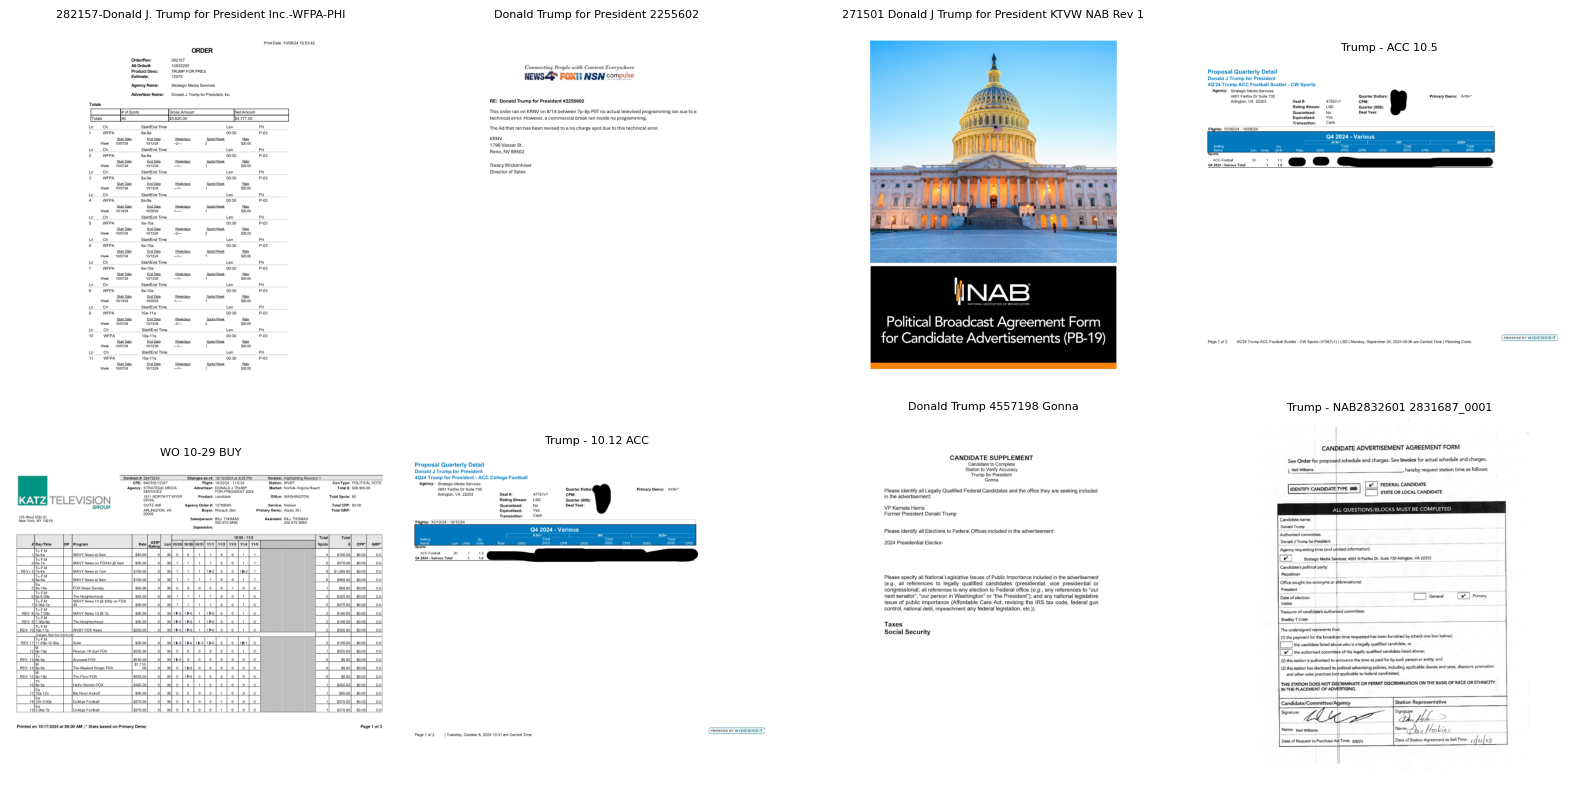

In [69]:
n = 8
samples = not_inv_in_title_df.sample(n)
show_images(bucket_name, samples)

* hmm, we can see that most of the files that do not contain 'invoice' hints in the file names are not invoices, indeed !  

* AI.BOOL method returned a lot of false positives

let's check the opposite: if there are files that were classified by both methods as not an invoice, but contain 'invoice hints' in their titles:

In [72]:
df.query("is_invoice_img == False & is_invoice_pdf == False", engine="python") \
  .loc[lambda x: x.file_name.str.contains("INV|Invoice", case=False,
                                           regex=True,
                                           na=False)]

,pdf_key,file_id,file_name,image_key,is_invoice_pdf,is_invoice_img


let's check if there any files that contain 'invoice hint' in the title, but were classified as not an invoice by using the pdf file:

In [71]:
df.query("is_invoice_img == True & is_invoice_pdf == False", engine="python") \
  .loc[lambda x: x.file_name.str.contains("INV|Invoice", case=False,
                                           regex=True,
                                           na=False)]

,pdf_key,file_id,file_name,image_key,is_invoice_pdf,is_invoice_img
89,gs://trump-political-ads-sample/FCC/docs/3e6f8...,3e6f8fc4-ee71-63a6-100b-571a41671b20,Donald J Trump for President 2024 est 12420 in...,gs://trump-political-ads-sample/FCC/docs/3e6f8...,False,True


as we can see from the image of the first page of the document, it was missclassified, indeed (false negative):

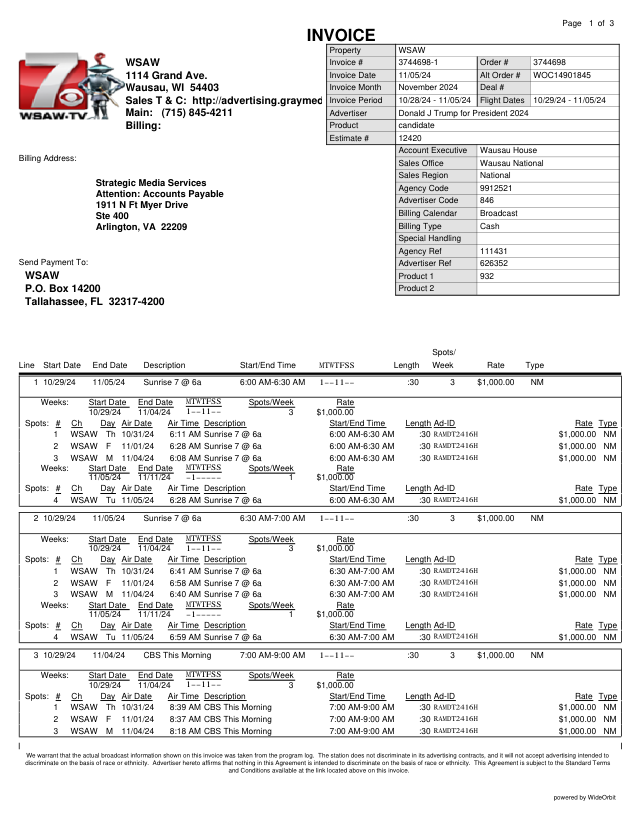

In [54]:
n=137
sample = df.loc[n]
show_image_page(bucket_name, sample['image_key'])

In [73]:
df.query("is_invoice_img == False & is_invoice_pdf == True", engine="python") \
  .loc[lambda x: x.file_name.str.contains("INV|Invoice", case=False,
                                           regex=True,
                                           na=False)]

,pdf_key,file_id,file_name,image_key,is_invoice_pdf,is_invoice_img


## Step 2. Invoice Classification: AI.GENERATE

* let's change the approach: we are going to use AI.GENERATE method;  

* we will construct a prompt to classify out files as one of ['invoice','contract','order', 'other'].

* we will work with only those files that were classified as 'is_invoice'= True by the AI.GENERATE_BOOL function, but have no 'inv|invoice' hint in the file name.

* out goal here is to use AI.GENERATE function to identify file documents which were incorrectly classified as 'invoice' ('is_invoice'=True) by the AI.GENERATE_BOOL function

### function

In [8]:


def classify_document_ai_generate(file_uri: str, model_endpoint: str) -> dict:
    """
    Classify a GCS file (PDF or image) into one of: invoice/contract/order/other.
    Returns: {"class": "..."}
    """
    sql = f"""
    WITH ai_call AS (
      SELECT
        AI.GENERATE(
          STRUCT(
            @prompt   AS prompt,
            @file_uri AS input,
            @schema   AS schema
          ),
          connection_id => '{CONNECTION_RESOURCE}',
          endpoint      => '{model_endpoint}'
        ) AS response
    )
    SELECT
      @file_uri AS file_processed,
      response.result        AS json_result,
      response.full_response AS raw_response
    FROM ai_call
    """

    job_cfg = bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("prompt", "STRING", CLASSIFICATION_PROMPT),
            bigquery.ScalarQueryParameter("file_uri", "STRING", file_uri),
            bigquery.ScalarQueryParameter("schema", "STRING", SCHEMA_JSON),
        ]
    )

    # IMPORTANT: pass region here, not in QueryJobConfig
    return bq_client.query(sql, job_config=job_cfg, location=REGION).to_dataframe()






#### classification and schema

In [9]:
# Prompt + schema
CLASSIFICATION_PROMPT = """
You are a document classification model.
Carefully read the provided document (it may be a PDF or an image of a PDF page).
Classify it strictly into one of the following categories:
- "invoice": a billing document that requests payment, typically includes amounts due, invoice numbers, dates, line items, and totals. It usually is entitled "Invoice" at the top of the first page
- "contract": a legal agreement between parties, often with clauses, obligations, terms, and signatures.
- "order": a purchase order or media order, often showing ordered items, placements, or services to be delivered, but not an actual invoice.
- "other": any document that does not clearly fit into the above three categories (e.g., disclosures, receipts, letters, media plans).
Return the result only as a valid JSON object with the following structure:
{"class": "<one of: invoice, contract, order, other>"}
""".strip()

SCHEMA_JSON = json.dumps({
    "type": "object",
    "properties": {
        "class": {"type": "string", "enum": ["invoice", "contract", "order", "other"]}
    },
    "required": ["class"]
})


### One-row smoke test


gs://trump-political-ads-sample/FCC/docs/16895893-ca10-0df5-8f84-d0560161b746/A9840-TRACT REV-102499-9.27.24/page_1.png
gs://trump-political-ads-sample/FCC/docs/16895893-ca10-0df5-8f84-d0560161b746/A9840-TRACT REV-102499-9.27.24/doc.pdf


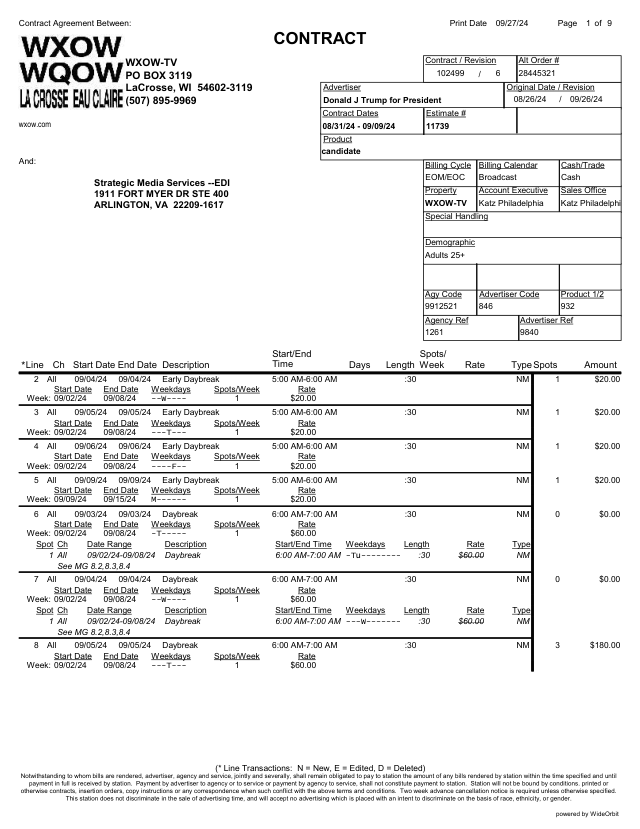

In [16]:
sample = not_inv_in_title_df.sample(1)
image_uri = sample['image_key'].tolist()[0]
print(image_uri)

pdf_uri = sample['pdf_key'].tolist()[0]
print(pdf_uri)
show_image_page(bucket_name, image_uri)

In [18]:
df = classify_document_ai_generate(image_uri, model_endpoint)
res = process_result(df)
print(res)

{'class': 'invoice'}


In [19]:
df = classify_document_ai_generate(pdf_uri, model_endpoint)
res = process_result(df)
print(res)

{'class': 'order'}


### all rows classification

#### using pdf files

In [54]:
DEST_TABLE   = f"{PROJECT_ID}.{DATASET_ID}.TRUMP_IMAGE_FLAGS"
MODEL_ENDPOINT = 'gemini-2.5-pro'

# Classify PDFs (pdf_key) into {"class": "..."} and save to DEST_TABLE
sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    pdf_key,
    REPLACE(REPLACE(pdf_key, 'gs://', 'https://storage.googleapis.com/'), ' ', '%20') AS url
  FROM `{SOURCE_TABLE}`
  WHERE pdf_key IS NOT NULL
    AND REGEXP_CONTAINS(LOWER(pdf_key), r'\\.pdf$')
),
calls AS (
  SELECT
    pdf_key,
    AI.GENERATE(
      STRUCT(@prompt AS prompt, url AS input, @schema AS schema),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => '{MODEL_ENDPOINT}'
    ) AS response
  FROM src
),
parsed AS (
  SELECT
    pdf_key,
    response.result        AS json_result,
    JSON_VALUE(response.result, '$.class') AS class,
    response.full_response AS raw_response
  FROM calls
)
SELECT
  pdf_key,
  class,
  json_result,
  raw_response
FROM parsed
"""

job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", CLASSIFICATION_PROMPT),
        bigquery.ScalarQueryParameter("schema", "STRING", SCHEMA_JSON),
    ]
)

bq_client.query(sql, job_config=job_cfg, location=REGION).result()
print("✅ Created:", DEST_TABLE)



✅ Created: data-science-455302.trump_campaign_us_central1.TRUMP_IMAGE_FLAGS


In [55]:
bq_client.query(f"""
UPDATE `{DEST_TABLE}`
SET class = COALESCE(
  JSON_VALUE(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    '$.class'
  ),
  REGEXP_EXTRACT(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    r'"class"\\s*:\\s*"(invoice|contract|order|other)"'
  )
)
WHERE class IS NULL
  AND json_result IS NOT NULL
""", location=REGION).result()

In [58]:
# 1) Add the column if it doesn't exist
add_col_sql = f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS doc_class_pdf STRING
"""
bq_client.query(add_col_sql, location=REGION).result()
print("✅ Column 'doc_class_pdf' ensured in SOURCE_TABLE")

# 2) Merge values from DEST_TABLE.class into SOURCE_TABLE.doc_class_pdf
merge_sql = f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` D
ON T.pdf_key = D.pdf_key
WHEN MATCHED AND D.class IS NOT NULL THEN
  UPDATE SET T.doc_class_pdf = D.class
"""
bq_client.query(merge_sql, location=REGION).result()
print("✅ Backfilled SOURCE_TABLE.doc_class_pdf from DEST_TABLE.class")


✅ Column 'doc_class_pdf' ensured in SOURCE_TABLE
✅ Backfilled SOURCE_TABLE.doc_class_pdf from DEST_TABLE.class


#### using first page images

In [45]:
sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    image_key,
    REPLACE(REPLACE(image_key, 'gs://', 'https://storage.googleapis.com/'), ' ', '%20') AS url
  FROM `{SOURCE_TABLE}`
  WHERE image_key IS NOT NULL
    AND REGEXP_CONTAINS(LOWER(image_key), r'\\.(png|jpg|jpeg)$')
),
calls AS (
  SELECT
    image_key,
    AI.GENERATE(
      STRUCT(@prompt AS prompt, url AS input, @schema AS schema),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => '{MODEL_ENDPOINT}'
    ) AS response
  FROM src
),
parsed AS (
  SELECT
    image_key,
    response.result        AS json_result,
    JSON_VALUE(response.result, '$.class') AS class,
    response.full_response AS raw_response
  FROM calls
)
SELECT
  image_key,
  class,
  json_result,
  raw_response
FROM parsed
"""


job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", CLASSIFICATION_PROMPT),
        bigquery.ScalarQueryParameter("schema", "STRING", SCHEMA_JSON),
    ]
)

bq_client.query(sql, job_config=job_cfg, location=REGION).result()
print("✅ Created:", DEST_TABLE)

✅ Created: data-science-455302.trump_campaign_us_central1.TRUMP_IMAGE_FLAGS


In [46]:
bq_client.query(f"""
UPDATE `{DEST_TABLE}`
SET class = COALESCE(
  JSON_VALUE(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    '$.class'
  ),
  REGEXP_EXTRACT(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    r'"class"\\s*:\\s*"(invoice|contract|order|other)"'
  )
)
WHERE class IS NULL
  AND json_result IS NOT NULL
""", location=REGION).result()

In [52]:
# 1) Add the column if it doesn't exist
add_col_sql = f"""
ALTER TABLE `{SOURCE_TABLE}`
ADD COLUMN IF NOT EXISTS doc_class_img STRING
"""
bq_client.query(add_col_sql, location=REGION).result()
print("✅ Column 'doc_class_img' ensured in SOURCE_TABLE")

# 2) Merge values from DEST_TABLE.class into SOURCE_TABLE.doc_class_img
merge_sql = f"""
MERGE `{SOURCE_TABLE}` T
USING `{DEST_TABLE}` D
ON T.image_key = D.image_key
WHEN MATCHED THEN
  UPDATE SET T.doc_class_img = D.class
"""
bq_client.query(merge_sql, location=REGION).result()
print("✅ Backfilled SOURCE_TABLE.doc_class_img from DEST_TABLE.class")

✅ Column 'doc_class_img' ensured in SOURCE_TABLE
✅ Backfilled SOURCE_TABLE.doc_class_img from DEST_TABLE.class


In [53]:
#  Quick verification: counts by class
check_sql = f"""
SELECT doc_class_img AS class, COUNT(*) AS n
FROM `{SOURCE_TABLE}`
WHERE doc_class_img IS NOT NULL
GROUP BY class
ORDER BY n DESC, class
"""
df = bq_client.query(check_sql, location=REGION).to_dataframe()
print(df)

      class    n
0   invoice  127
1     order  105
2  contract   59
3     other    7


# Analyze classification results

In [21]:
df = bq_client.query(
    f"""SELECT * FROM `{SOURCE_TABLE}`""").to_dataframe()
df.shape

(298, 8)

In [61]:
df.head()

,pdf_key,file_id,file_name,image_key,is_invoice_pdf,is_invoice_img,doc_class_img,doc_class_pdf
0,gs://trump-political-ads-sample/FCC/docs/d560d...,d560d6ca-31f2-9917-28a6-10af7404d348,_MAGA Inc. NAB PB-19 (Signed)_2,gs://trump-political-ads-sample/FCC/docs/d560d...,False,False,contract,contract
1,gs://trump-political-ads-sample/FCC/docs/6e12d...,6e12d5c6-d045-d5e5-d101-73efef781fa4,Donald J. Trump for President confirmation con...,gs://trump-political-ads-sample/FCC/docs/6e12d...,False,False,contract,contract
2,gs://trump-political-ads-sample/FCC/docs/e6b33...,e6b33d29-c8ad-6382-0891-3f7133cb2090,A9840-NAB-REV-113187-10.28.24,gs://trump-political-ads-sample/FCC/docs/e6b33...,True,True,contract,contract
3,gs://trump-political-ads-sample/FCC/docs/28919...,2891915d-8b0f-0a40-3753-50034c812d04,WAXN - POL - D TRUMP - R - PRES - NAB - CONTRA...,gs://trump-political-ads-sample/FCC/docs/28919...,False,True,contract,contract
4,gs://trump-political-ads-sample/FCC/docs/f59a8...,f59a8e4c-91ba-dc2f-e2c8-a50c91ae01a1,_Trump General NAB (Signed)_2,gs://trump-political-ads-sample/FCC/docs/f59a8...,False,True,contract,contract


by applying AI.GENERATE the number of documents that are classified as 'invoice' decreased from 146 (with AI.BOOL only) to 83

In [65]:
not_inv_in_title_df1 = inv_df.loc[lambda x: ~x.file_name.str.contains("INV|Invoice", case=False,
                                           regex=True,
                                           na=False)].copy()
not_inv_in_title_df1.shape

(23, 8)

* the number of

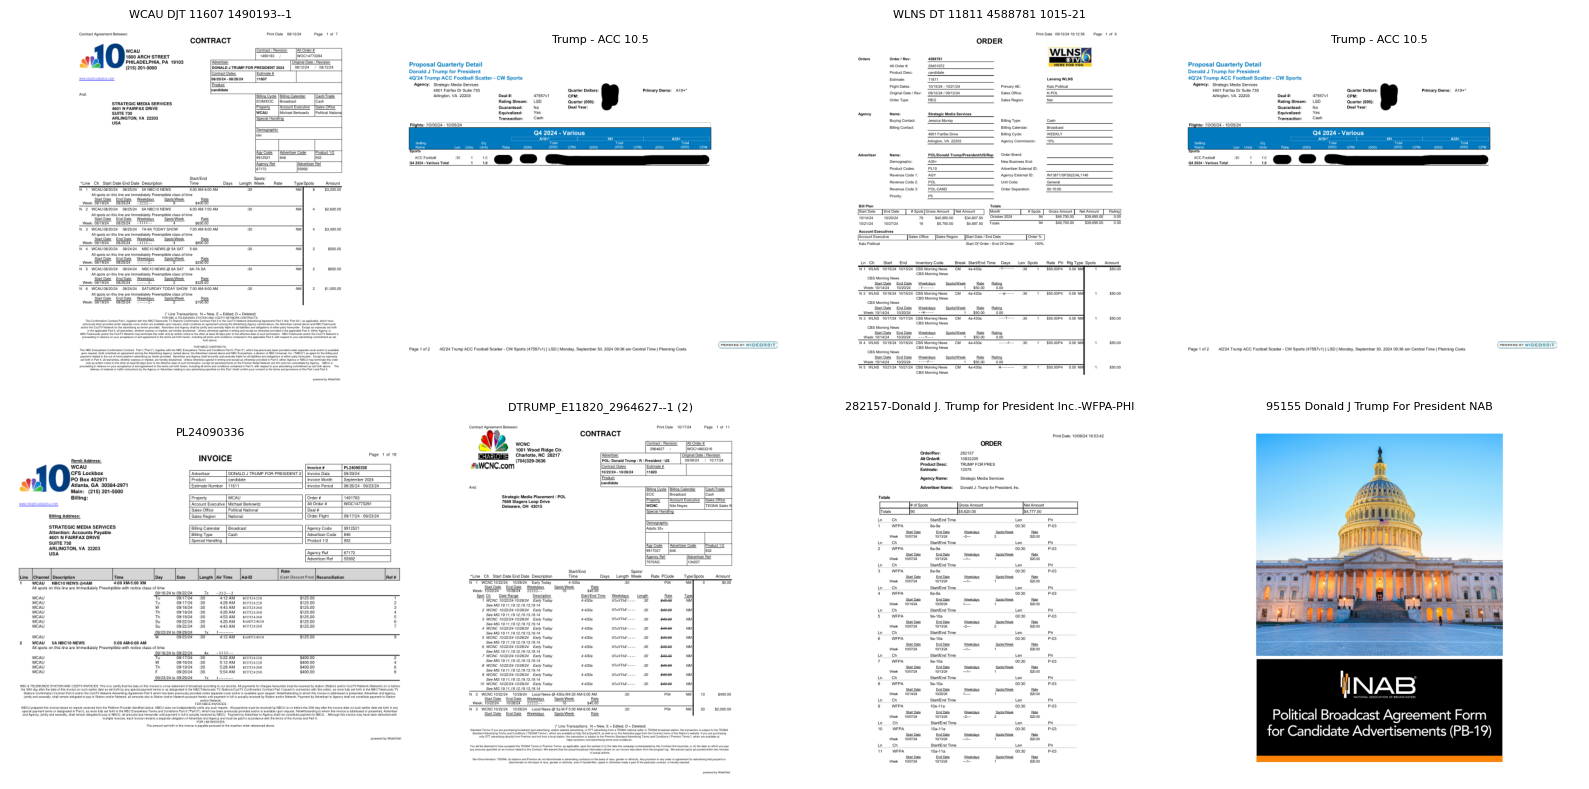

In [73]:
n = 8
samples = not_inv_in_title_df1.sample(n)
show_images(bucket_name, samples)

even though the number of False positives decreased from 85 to 23 after we added AI.GENERATE method, the model still struggles with correctly classifyng the documents.

# adjusted prompt

let's change the prompt and see if the results are improved

In [85]:
CLASSIFICATION_PROMPT = """
You are a document classification model.
Carefully read the provided document (it may be a PDF or an image of a PDF page).
Classify it strictly into one of the following categories:

- "invoice": a billing document that requests payment, typically includes amounts due, invoice numbers, dates, line items, and totals. It usually is entitled "Invoice" at the top of the first page.
- "contract": a legal agreement between parties, often with clauses, obligations, terms, and signatures. It usually is entitled "Contract" or "Agreement" at the top of the first page.
- "order": a purchase order or media order, often showing ordered items, placements, or services to be delivered, but not an actual invoice. It usually is entitled "Order" or "Purchase Order" at the top of the first page.
- "other": any document that does not clearly fit into the above three categories (e.g., disclosures, receipts, letters, media plans).

Return the result only as a valid JSON object with the following structure:
{"class": "<one of: invoice, contract, order, other>"}
""".strip()


gs://trump-political-ads-sample/FCC/docs/48ff7965-e456-a6a3-59d0-a4e9c47a3f4d/TRUMP R PRESIDENT 4110890/page_1.png
gs://trump-political-ads-sample/FCC/docs/48ff7965-e456-a6a3-59d0-a4e9c47a3f4d/TRUMP R PRESIDENT 4110890/doc.pdf


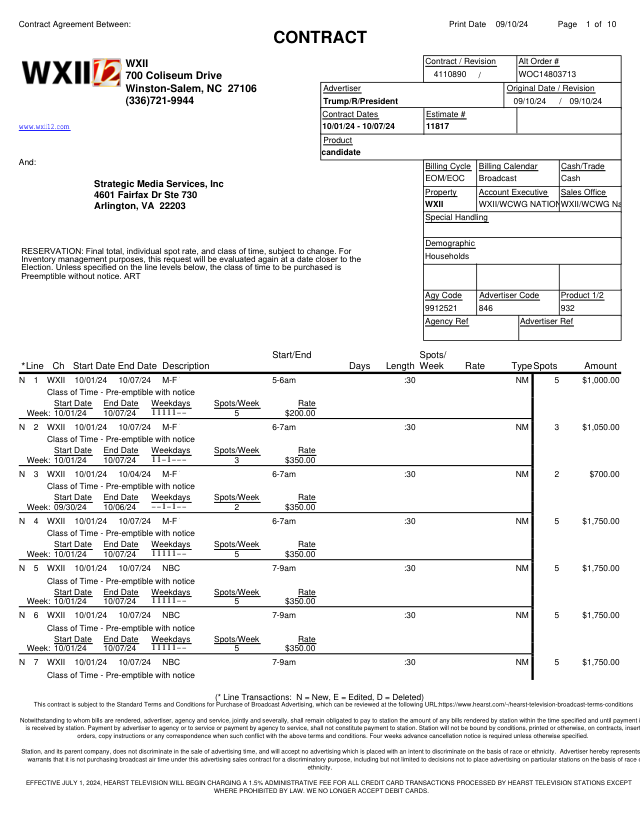

In [80]:
sample = not_inv_in_title_df1.sample(1)
image_uri = sample['image_key'].tolist()[0]
print(image_uri)

pdf_uri = sample['pdf_key'].tolist()[0]
print(pdf_uri)
show_image_page(bucket_name, image_uri)

In [81]:
df = classify_document(image_uri, model_endpoint)
res = process_result(df)
print(res)

{'class': 'contract'}


In [82]:
df = classify_document(pdf_uri, model_endpoint)
res = process_result(df)
print(res)

{'class': 'invoice'}


In [86]:
sql = f"""
CREATE OR REPLACE TABLE `{DEST_TABLE}` AS
WITH src AS (
  SELECT
    image_key,
    REPLACE(REPLACE(image_key, 'gs://', 'https://storage.googleapis.com/'), ' ', '%20') AS url
  FROM `{SOURCE_TABLE}`
  WHERE image_key IS NOT NULL
    AND REGEXP_CONTAINS(LOWER(image_key), r'\\.(png|jpg|jpeg)$')
),
calls AS (
  SELECT
    image_key,
    AI.GENERATE(
      STRUCT(@prompt AS prompt, url AS input, @schema AS schema),
      connection_id => '{CONNECTION_RESOURCE}',
      endpoint      => '{MODEL_ENDPOINT}'
    ) AS response
  FROM src
),
parsed AS (
  SELECT
    image_key,
    response.result        AS json_result,
    JSON_VALUE(response.result, '$.class') AS class,
    response.full_response AS raw_response
  FROM calls
)
SELECT
  image_key,
  class,
  json_result,
  raw_response
FROM parsed
"""


job_cfg = bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter("prompt", "STRING", CLASSIFICATION_PROMPT),
        bigquery.ScalarQueryParameter("schema", "STRING", SCHEMA_JSON),
    ]
)

bq_client.query(sql, job_config=job_cfg, location=REGION).result()
print("✅ Created:", DEST_TABLE)

✅ Created: data-science-455302.trump_campaign_us_central1.TRUMP_IMAGE_FLAGS


In [88]:
bq_client.query(f"""
UPDATE `{DEST_TABLE}`
SET class = COALESCE(
  JSON_VALUE(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    '$.class'
  ),
  REGEXP_EXTRACT(
    TRIM(
      REGEXP_REPLACE(
        REGEXP_REPLACE(json_result, r'```\\s*json\\s*', ''),
        r'```', ''
      )
    ),
    r'"class"\\s*:\\s*"(invoice|contract|order|other)"'
  )
)
WHERE class IS NULL
  AND json_result IS NOT NULL
""", location=REGION).result()

In [91]:
check_sql = f"""
SELECT class, COUNT(*) AS n
FROM `{DEST_TABLE}`
WHERE class IS NOT NULL
GROUP BY class
ORDER BY n DESC, class
"""
df = bq_client.query(check_sql, location=REGION).to_dataframe()
print(df)

      class    n
0   invoice  137
1     order  109
2  contract   41
3     other   11


###

So, we did a model run with the tweaked CLASSIFICAITON_PROMPT, in which we tried to help the model by looking at the document titles at the top of the first page.  

However, the model did not adjust its classification results: still 137 documents are classified as invoices, and that's even higher number than 127 with the original prompt (see "Step 2. Invoice Classification: AI.GENERATE/all rows classification/using first page images")

# Conclusion



In this notebook, we evaluated BigQuery’s built-in AI functions for classifying Trump campaign financial documents. The goals were twofold: first, to determine whether documents could be reliably identified as invoices using both AI.GENERATE\_BOOL and AI.GENERATE with the gemini-2.5-pro model; and second, to prepare data for downstream analysis of campaign spending totals, distributed across TV stations and programs. Accurate invoice detection is essential because invoices are the primary source for extracting financial line items. Classification also helps optimize costs by constraining the model to minimal outputs: **True/False** in the case of AI.GENERATE\_BOOL and a single document class in the case of AI.GENERATE.

The main findings are:

* **Low accuracy of AI.GENERATE\_BOOL**: Despite being cost-efficient and simple, the boolean classification produced a high number of false positives. Out of \~298 documents, it labeled 184–209 as invoices, whereas heuristic analysis of filenames suggested the true count was closer to 62.

* **Improvement with AI.GENERATE + schema**: By switching to multi-class classification (invoice, contract, order, other), the number of predicted invoices dropped from 146 to 83. This significantly reduced false positives (from 85 down to 23), though the model still struggled to disambiguate between invoices and related documents such as orders and contracts.

* **Image vs. PDF trade-off**: Using first-page images reduced token costs while still providing enough context for classification, but results were inconsistent. Whole PDFs gave better context, but at much higher token usage and still did not yield strong accuracy.

* **Prompt engineering helps but is insufficient**: Adjusted prompts (e.g., clarifying what counts as “invoice,” “contract,” or “order”) improved results marginally, but model misclassification remained a recurring issue.

**Recommendation: Prompt Caching for Multi‑Modal, Multi‑Function Runs**

Because this workflow invokes two functions (**AI.GENERATE\_BOOL** and **AI.GENERATE**) across two modalities (first‑page **images** and full **PDFs**), repeated prompts lead to redundant compute for near‑identical requests. An optional **prompt caching** capability at the BigQuery AI layer (keyed by normalized prompt + model + input hash) would:

* Reduce latency and cost for retries and iterative prompt tuning;
* Enable idempotent re‑runs when only downstream SQL changes;
* Improve team reproducibility by ensuring identical cached results for identical inputs.

Overall, the experiments show that Gemini models within BigQuery are not yet reliable for direct invoice detection in complex political campaign documents. However, the pipeline we built demonstrates the feasibility of running large-scale classification directly in SQL, storing outputs in BigQuery tables, and comparing methods (image vs. PDF, binary vs. multi-class).

The work highlights the limits of current LLM-based classification on financial/legal documents and points to future directions: combining LLMs with heuristic filters, metadata hints (like filenames), or vector search for better accuracy. This conclusion aligns with the competition’s emphasis on building prototypes that both showcase BigQuery AI and reveal real-world challenges when applying it to messy, unstructured data.


## Precision and recall

In [40]:
# index of true invoice labels
true_labels_idx = df.query("file_name.str.contains('inv',case=False)").index
print("Number of true invoices: ", len(true_labels_idx))

q="is_invoice_img==True & is_invoice_pdf==True & doc_class_img=='invoice' & doc_class_pdf=='invoice'"
inv_df_idx = df.query(q, engine='python').index
print("Number of documents classified as invoices: ", len(inv_df_idx))

TP = len(true_labels_idx.intersection(inv_df_idx))

print("Number of TP (true positives): ", TP)

FP = len(inv_df_idx.difference(true_labels_idx))
print("Number of FP (false positives): ", FP)

FN = len(true_labels_idx.difference(inv_df_idx))
print("Number of FN (false negatives): ", FN)

TN = len(df) - (TP+FP+FN)
print("Number of TN (true negatives): ", TN)

Number of true invoices:  62
Number of documents classified as invoices:  83
Number of TP (true positives):  60
Number of FP (false positives):  23
Number of FN (false negatives):  2
Number of TN (true negatives):  213


In [44]:
precision = TP / (TP + FP)
print(f"Precision: {precision: .2f}")

recall = TP / (TP + FN)
print(f"Recall: {recall: .2f}")

Precision:  0.72
Recall:  0.97


### Confusion Matrix (Invoice Classification)

The confusion matrix below summarizes the performance of our model on 298 documents.  
It highlights the tradeoff between recall and precision:

- **TP (True Positives): 60** → Correctly classified invoices  
- **FP (False Positives): 23** → Orders/contracts misclassified as invoices  
- **FN (False Negatives): 2** → Invoices missed by the model  
- **TN (True Negatives): 213** → Correctly identified non-invoices


## confusion matrix

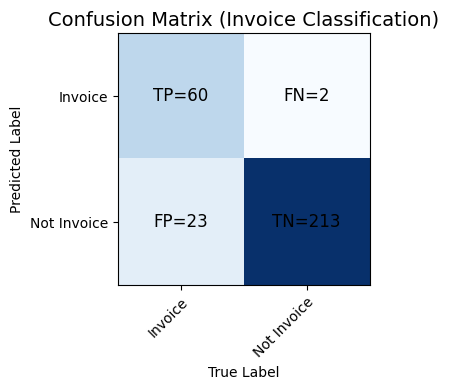

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix values from analysis
TP = 60
FP = 23
FN = 2
TN = 213  # total docs = 298, so TN = 298 - (TP+FP+FN)

# Confusion matrix
cm = np.array([[TP, FN],
               [FP, TN]])

labels = [["TP=60", "FN=2"],
          ["FP=23", "TN=213"]]

fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap="Blues")

# Show all ticks and label them
ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Invoice", "Not Invoice"])
ax.set_yticklabels(["Invoice", "Not Invoice"])

# Rotate tick labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Annotate each cell with value
for i in range(2):
    for j in range(2):
        ax.text(j, i, labels[i][j],
                ha="center", va="center", color="black", fontsize=12)

ax.set_title("Confusion Matrix (Invoice Classification)", fontsize=14)
ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")

plt.tight_layout()
plt.show()
